# Sequence Processing with HMMs and CRFs

## SOYKOK Aylin 28711545 - CELIK Simay 28713301

**The goal of this practical is to study sequence models in NLP.**

We will work on Part-Of-Speech (POS) and optionally on chunking (gathering different groups in sentences). The datasets are from [CONLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/): 
- **Small corpus:** chtrain/chtest to understand the tools and models 
- **Larger corpus:** train/test to collect reliable experimental results


# 1) HMMS


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


C:\Users\PC\AppData\Local\Temp\ipykernel_26420\1015374048.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Loading POS/Chunking data
def load(filename):
    listeDoc = list()
    with open(filename, "r") as f:
        doc = list()
        for ligne in f:
            if len(ligne) < 2: # fin de doc
                listeDoc.append(doc)
                doc = list()
                continue
            mots = ligne.replace("\n","").split(" ")
            doc.append((mots[0],mots[1])) # Change mots[1] -> mots[2] for chuncking
    return listeDoc

In [3]:
# =============== loding ============
# small corpus => ideal for first tests
filename = "./datasets/conll2000/chtrain.txt" 
filenameT = "./datasets//conll2000/chtest.txt" 

# Larger corpus => To valide perf.
# filename = "ressources/conll2000/train.txt" 
# filenameT = "ressources/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")

823  docs read
77  docs (T) read


In [4]:
print(alldocs[0])
print(alldocsT[0])

[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to', 'TO'), ('provide', 'VB'), ('structural', 'JJ'), ('parts', 'NNS'), ('for', 'IN'), ('Boeing', 'NNP'), ("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS'), ('.', '.')]
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from'

## Building a baseline POS model (without sequence)

We will build a simple dictionary ```word => PoS label``` without taking into account any sequence information. We will compare the sequence models to this baseline.

The dataset is a list a tuples with ```(word, POS)```. **Build a simple dictionary mapping each word to its PoS tag in the train set**

In [5]:
# Dictionary building 
dico = dict()
#les clés sont les mots et les valeurs sont les labels PoS
print()
for doc in alldocs:
    for (word, label) in doc:
        dico[word] = label

dico

{'Rockwell': 'NNP',
 'International': 'NNP',
 'Corp.': 'NNP',
 "'s": 'POS',
 'Tulsa': 'NNP',
 'unit': 'NN',
 'said': 'VBD',
 'it': 'PRP',
 'signed': 'VBD',
 'a': 'DT',
 'tentative': 'JJ',
 'agreement': 'NN',
 'extending': 'VBG',
 'its': 'PRP$',
 'contract': 'NN',
 'with': 'IN',
 'Boeing': 'NNP',
 'Co.': 'NNP',
 'to': 'TO',
 'provide': 'VB',
 'structural': 'JJ',
 'parts': 'NNS',
 'for': 'IN',
 '747': 'CD',
 'jetliners': 'NNS',
 '.': '.',
 'the': 'DT',
 'calls': 'VBZ',
 'supply': 'VB',
 '200': 'CD',
 'additional': 'JJ',
 'so-called': 'JJ',
 'shipsets': 'NNS',
 'planes': 'NNS',
 'These': 'DT',
 'include': 'VBP',
 ',': ',',
 'among': 'IN',
 'other': 'JJ',
 'each': 'DT',
 'jetliner': 'NN',
 'two': 'CD',
 'major': 'JJ',
 'bulkheads': 'NNS',
 'pressure': 'NN',
 'floor': 'NN',
 'torque': 'NN',
 'box': 'NN',
 'fixed': 'VBN',
 'leading': 'VBG',
 'edges': 'NNS',
 'wings': 'NNS',
 'and': 'CC',
 'an': 'DT',
 'aft': 'JJ',
 'keel': 'NN',
 'beam': 'NN',
 'Under': 'IN',
 'existing': 'VBG',
 'has': 'VBZ

**Note: on the test set, there are unknown words...**. We will use the following simple strategy: 
```
# remplace
dico[cle] # crashing with an unknown key 
# by 
dico.get(cle, DefaultValue)
```
From a linguistic point of view, we can choose the default value as the majority PoS class, producing a stronger baseline.

In [6]:
# Evaluate test performances
cpt_empty = 0 #counter of good predictions
cpt_NN = 0
total = 0
for doc in alldocsT:
    for (word, label) in doc:
        total+=1
        if dico.get(word,'') == label:
            cpt_empty+=1
        if dico.get(word,'NN') == label:
            cpt_NN+=1
print("For '' as default PoS value")
print("Accuracy = ",cpt_empty/total)
print("Nb of good predictions = ",cpt_empty)
print("Nb of words in total = ",total)
print("____________________________")
print("For 'NN' as default PoS value")
print("Accuracy = ",cpt_NN/total)
print("Nb of good predictions = ",cpt_NN)
print("Nb of words in total = ",total)

For '' as default PoS value
Accuracy =  0.755801687763713
Nb of good predictions =  1433
Nb of words in total =  1896
____________________________
For 'NN' as default PoS value
Accuracy =  0.805379746835443
Nb of good predictions =  1527
Nb of words in total =  1896


Check: 1433 good predictions in test over 1896

(1527 with 'NN' as default PoS value)

## HMMs

Here is a code for training HMM parameters and running decoding using the Viterbi algorithm. You should apply it to our PoS task. **N.B.: you should undersand the ```eps``` parmaters**.


In [7]:
# allx: list of observation sequences 
# allq: list os state sequences 
# N: nb states
# K: nb observations

def learnHMM(allx, allq, N, K, initTo1=True):
    if initTo1:
        eps = 1e-3 # You can play with this regularization parameter 
        A = np.ones((N,N))*eps
        B = np.ones((N,K))*eps
        Pi = np.ones(N)*eps
    else:
        A = np.zeros((N,N))
        B = np.zeros((N,K))
        Pi = np.zeros(N)
    for x,q in zip(allx,allq):
        Pi[int(q[0])] += 1
        for i in range(len(q)-1):
            A[int(q[i]),int(q[i+1])] += 1
            B[int(q[i]),int(x[i])] += 1
        B[int(q[-1]),int(x[-1])] += 1 # last transition
    A = A/np.maximum(A.sum(1).reshape(N,1),1) # normalisation
    B = B/np.maximum(B.sum(1).reshape(N,1),1) # normalisation
    Pi = Pi/Pi.sum()
    return Pi , A, B

def viterbi(x,Pi,A,B):
    T = len(x)
    N = len(Pi)
    logA = np.log(A)
    logB = np.log(B)
    logdelta = np.zeros((N,T))
    psi = np.zeros((N,T), dtype=int)
    S = np.zeros(T)
    logdelta[:,0] = np.log(Pi) + logB[:,int(x[0])]
    #forward
    for t in range(1,T):
        logdelta[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).max(0) + logB[:,int(x[t])]
        psi[:,t] = (logdelta[:,t-1].reshape(N,1) + logA).argmax(0)
    # backward
    logp = logdelta[:,-1].max()
    S[T-1] = logdelta[:,-1].argmax()
    for i in range(2,T+1):
        S[int(T-i)] = psi[int(S[int(T-i+1)]),int(T-i+1)]
    return S, logp #, delta, psi
 

### Data encoding

We will map each word to an index for traing the HMM (see code below):
```
 The cat is in the garden => 1 2 3 4 1 5
```
We have to understand the dictionary functionning to retrieve the words corresponding to indices.

In [8]:
# alldocs etant issu du chargement des données
# la mise en forme des données est fournie ici
# afin de produire des analyses qualitative, vous devez malgré tout comprendre le fonctionnement des dictionnaires

buf = [[m for m,pos in d ] for d in alldocs] # m = word; buf = all words in all docs
mots = []
[mots.extend(b) for b in buf] # matrix of words to words
mots = np.unique(np.array(mots)) # all unique words
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots)))) #indexed words in a dict
mots2ind["UUUUUUUU"] = len(mots) #added the unknown word

buf2 = [[pos for m,pos in d ] for d in alldocs] #same for labels
cles = []
[cles.extend(b) for b in buf2] #same for labels
cles = np.unique(np.array(cles)) #same for labels
cles2ind = dict(zip(cles,range(len(cles)))) #same for labels

nCles = len(cles) #no label for unknown word

print(nMots,nCles," in the dictionary")

# mise en forme des données
# indexes of each word/label in docs
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
allqT = [[cles2ind.setdefault(pos,len(cles)) for m,pos in d] for d in alldocsT]

4570 42  in the dictionary


In [9]:
# First doc:
print(allx[0])
print(allq[0])

[1140, 814, 563, 11, 1294, 4393, 3855, 2854, 3992, 1362, 4242, 1452, 2395, 2855, 1990, 4529, 446, 525, 4299, 3595, 4148, 3368, 2499, 446, 11, 283, 2861, 20]
[18, 18, 18, 22, 18, 17, 32, 23, 32, 9, 13, 17, 33, 24, 17, 12, 18, 18, 29, 31, 13, 20, 12, 18, 22, 8, 20, 5]


## You turn: apply HMMs to those data!

In [10]:
# HMM training 
# YOUR CODE HERE
Pi, A, B = learnHMM(allx, allq, nCles, nMots)
Pi, A, B

(array([1.21500482e-06, 1.21500482e-06, 1.21500482e-06, 1.21500482e-06,
        1.21500482e-06, 1.21500482e-06, 3.64622948e-03, 4.13113790e-02,
        1.09362584e-02, 2.08982045e-01, 3.64622948e-03, 1.21500482e-06,
        1.19071688e-01, 3.28063452e-02, 3.64622948e-03, 3.64622948e-03,
        1.21500482e-06, 2.79463259e-02, 2.32067136e-01, 1.21500482e-06,
        5.10314176e-02, 1.21500482e-06, 1.21500482e-06, 7.04714948e-02,
        1.09362584e-02, 4.73864031e-02, 1.21621983e-03, 1.21500482e-06,
        1.21500482e-06, 2.43122465e-03, 1.21500482e-06, 4.86123430e-03,
        1.21500482e-06, 1.70112825e-02, 9.72125359e-03, 1.21500482e-06,
        1.21621983e-03, 1.21500482e-06, 1.21500482e-06, 1.21500482e-06,
        7.29124395e-03, 8.86965671e-02]),
 array([[6.32743195e-06, 6.32743195e-06, 6.32743195e-06, ...,
         6.32743195e-06, 6.32743195e-06, 6.32743195e-06],
        [1.18988125e-05, 1.18988125e-05, 1.18988125e-05, ...,
         1.18988125e-05, 1.18988125e-05, 1.18988125e-05]

In [11]:
# HMM decoding and performances evaluation
# YOUR CODE HERE
cpt = 0
total = 0
S = None
for x,q in zip(allxT,allqT):
    S, _ = viterbi(x,Pi,A,B)
    for l1,l2 in zip(S,q):
        total+=1
        if l1==l2 : cpt+=1
print(f'{cpt} good predictions in {total}')

1538 good predictions in 1896


Check : 1564 in test

### Qualitative Analyis:

- With imshow on the parameters (ou d'un argsort), show what are the probable transition between labels.
- Visualize the confusion matrices to understand what is challenging in this task
- Find out examples that are corrected by Viterbi decoding



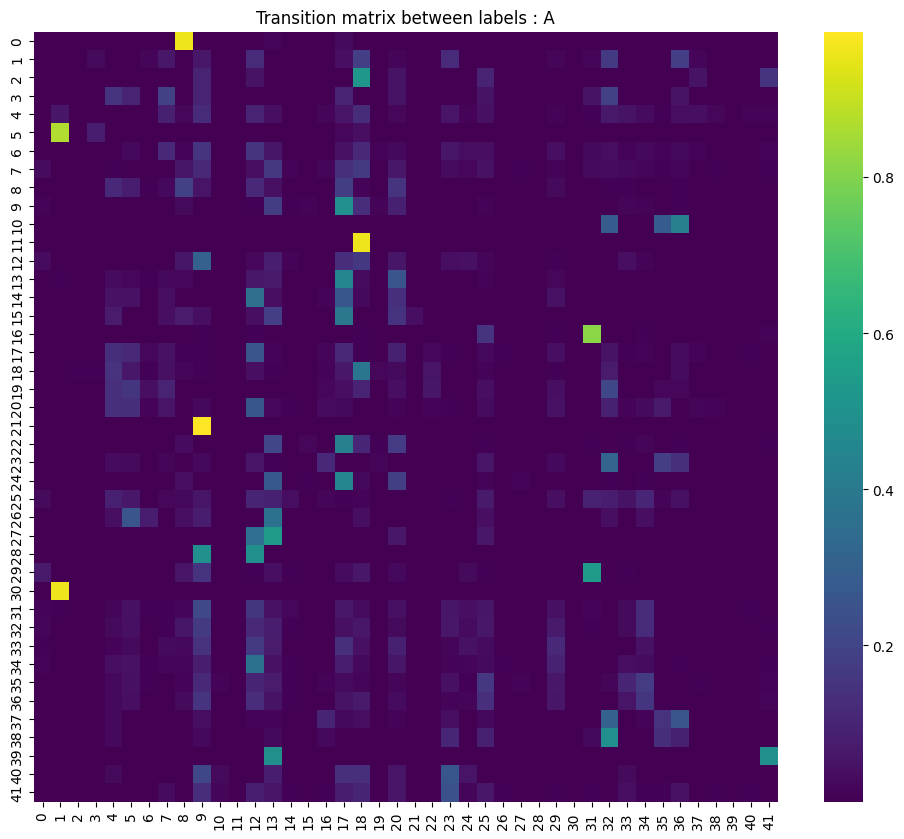

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(A,cmap='viridis')
plt.title("Transition matrix between labels : A")
plt.show()

Yellow dots mean transition between these are more probable while darker colors mean less probability. We see that most transitions are rare.


In [13]:
#confusion matrix 
conf = np.zeros((nCles+1,nCles+1))
for x,q in zip(allxT,allqT):
    S, _ = viterbi(x,Pi,A,B)
    for l1,l2 in zip(S,q):
        conf[int(l1),l2] += 1


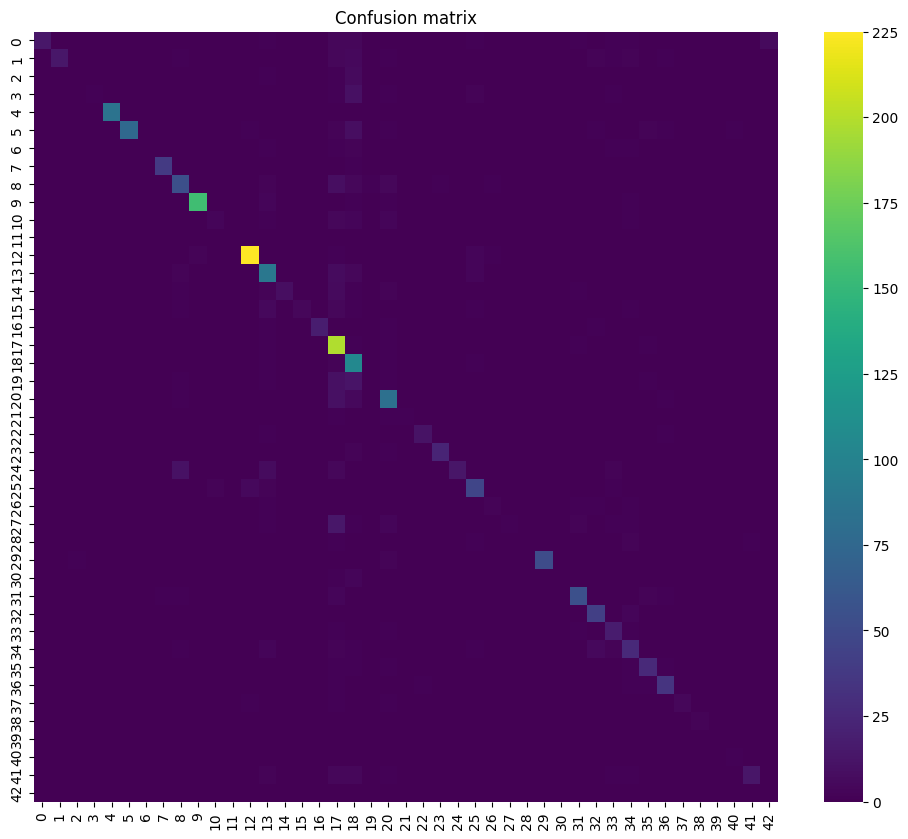

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(conf,cmap='viridis')
plt.title("Confusion matrix")
plt.show()

In [15]:
# examples that were decoded fully correctly by Viterbi decoding
correct = []
for x, q in zip(allxT, allqT):
    S, _ = viterbi(x, Pi, A, B)
    if  np.array_equal(S, q):
        correct.append((x, q, S))

print("Nb of fully correct",len(correct))


Nb of fully correct 3


# 2) Conditional Random Fields (CRF)

**CRF are disciminative models** representing the conditional distribution $P( \mathbf{y} | \mathbf{x} , \mathbf{w})$:

$$ P( \mathbf{y} | \mathbf{x} , \mathbf{w})  = \frac{e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}) } }{\sum\limits_{y' \in \mathcal{y}}e^{\mathbf{w}^T  \psi(\mathbf{x},\mathbf{y}') } } $$ 
        
**In 'linear-chain' CRFs**, the feature functions include **unary terms $u_k$** ($\sim$ $\mathbf{B}$ matrix in HMMs) and **pairwise terms $p_k$** ($\sim$ $\mathbf{A}$ matrix in HMMs):

$$ \mathbf{w}^T \psi(\mathbf{x},\mathbf{y}) = \sum\limits_{t=1}^T \sum_{k=1}^K F_k(y_{t-1}, y_t, \mathbf{x})  =   \sum\limits_{t=1}^T \sum_{k=1}^K \left[ u_k(y_t, \mathbf{x}) + p_k(y_{t-1}, y_t, \mathbf{x}) \right]$$

[<img src="https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png" width="800" >](https://thome.isir.upmc.fr/classes/RITAL/crf-obs2.png)


We can directly use resources from nltk: 
- [CRFTagger](https://tedboy.github.io/nlps/generated/generated/nltk.CRFTagger.html)
- [PerceptronTagger](https://www.nltk.org/_modules/nltk/tag/perceptron.html)

In [17]:
#!pip install python-crfsuite
from nltk.tag.crf import CRFTagger
tagger = CRFTagger()
tagger.train(alldocs, 'out/crf.model') # training

### Training and evaluating the model, as before

In [22]:
acc = tagger.accuracy(alldocsT)
flat_alldocs = np.concatenate([np.asarray(l) for l in alldocsT])
print("ACCURACY :",acc)
print("Nb of correct results :", acc*len(flat_alldocs))

ACCURACY : 0.9071729957805907
Nb of correct results : 1720.0


Check: 1720 bonnes réponses

In [26]:
# perceptron
from nltk.tag.perceptron    import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)

In [27]:
acc = tagger.accuracy(alldocsT)
flat_alldocs = np.concatenate([np.asarray(l) for l in alldocsT])
print("ACCURACY :",acc)
print("Nb of correct results :", acc*len(flat_alldocs))

ACCURACY : 0.9187763713080169
Nb of correct results : 1742.0


Check: 1737 bonnes réponses

# Going further

- We test the application for PoS, we can run similar experiments for chunking (see parsing indication, very simple to load data)
- Run  experiement on the larger dataset. This dataset is still largely used in research. This work can thus be included in your resume :)
- Work will be purshed with word embeddings (next practical), and for [NER](https://www.clips.uantwerpen.be/conll2003/ner/) with RNNs (X. Tannier)
- [State-of-the-art resources](https://github.com/stanfordnlp/stanza/)

In [52]:
# Larger corpus => To valide perf.
filename = "datasets/conll2000/train.txt" 
filenameT = "datasets/conll2000/test.txt" 

alldocs = load(filename)
alldocsT = load(filenameT)

In [53]:


print(len(alldocs)," docs read")
print(len(alldocsT)," docs (T) read")
print(alldocs[0])
print(alldocsT[0])

# Dictionary building 
dico = dict()
#les clés sont les mots et les valeurs sont les labels PoS
print()
for doc in alldocs:
    for (word, label) in doc:
        dico[word] = label
# Evaluate test performances
cpt_empty = 0 #counter of good predictions
cpt_NN = 0
total = 0
for doc in alldocsT:
    for (word, label) in doc:
        total+=1
        if dico.get(word,'') == label:
            cpt_empty+=1
        if dico.get(word,'NN') == label:
            cpt_NN+=1
print("For '' as default PoS value")
print("Accuracy = ",cpt_empty/total)
print("Nb of good predictions = ",cpt_empty)
print("Nb of words in total = ",total)
print("____________________________")
print("For 'NN' as default PoS value")
print("Accuracy = ",cpt_NN/total)
print("Nb of good predictions = ",cpt_NN)
print("Nb of words in total = ",total)

8936  docs read
2012  docs (T) read
[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')]
[('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP'), ("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN'), ('said', 'VBD'), ('it', 'PRP'), ('signed', 'VBD'), ('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN'), ('extending', 'VBG'), ('its', 'PRP$'), ('contract', 'NN'), ('with', 'IN'), ('Boeing', 'NNP'), ('Co.', 'NNP'), ('to

In [54]:

buf = [[m for m,pos in d ] for d in alldocs] # m = word; buf = all words in all docs
mots = []
[mots.extend(b) for b in buf] # matrix of words to words
mots = np.unique(np.array(mots)) # all unique words
nMots = len(mots)+1 # mot inconnu

mots2ind = dict(zip(mots,range(len(mots)))) #indexed words in a dict
mots2ind["UUUUUUUU"] = len(mots) #added the unknown word

buf2 = [[pos for m,pos in d ] for d in alldocs] #same for labels
cles = []
[cles.extend(b) for b in buf2] #same for labels
cles = np.unique(np.array(cles)) #same for labels
cles2ind = dict(zip(cles,range(len(cles)))) #same for labels

nCles = len(cles) #no label for unknown word

print(nMots,nCles," in the dictionary")

# mise en forme des données
# indexes of each word/label in docs
allx  = [[mots2ind[m] for m,pos in d] for d in alldocs]
allxT = [[mots2ind.setdefault(m,len(mots)) for m,pos in d] for d in alldocsT]

allq  = [[cles2ind[pos] for m,pos in d] for d in alldocs]
# First doc:
print(allx[0])
print(allq[0])

19123 44  in the dictionary
[3068, 12557, 17919, 15074, 12916, 18921, 11125, 18064, 17758, 7826, 16693, 10436, 12470, 18146, 11397, 11597, 6398, 24, 10616, 11597, 15914, 18078, 24, 11229, 18064, 16777, 7393, 17545, 12552, 11752, 4554, 7798, 2331, 21, 14042, 10027, 31]
[18, 13, 10, 18, 38, 26, 36, 31, 33, 10, 14, 18, 13, 18, 21, 13, 19, 5, 14, 13, 18, 18, 5, 33, 31, 33, 10, 14, 18, 13, 19, 8, 19, 23, 14, 21, 6]


In [55]:
# HMM training 

Pi, A, B = learnHMM(allx, allq, nCles, nMots)
# HMM decoding and performances evaluation

cpt = 0
total = 0
correct = [] #correct decoding
for x,q in zip(allxT,allqT):
    S, _ = viterbi(x,Pi,A,B)
    if  np.array_equal(S, q):
        correct.append((x, q, S))
    for l1,l2 in zip(S,q):
        total+=1
        if l1==l2 : cpt+=1

print(f'{cpt} good predictions in {total}')

#confusion matrix 
conf = np.zeros((nCles+1,nCles+1))
for x,q in zip(allxT,allqT):
    S, _ = viterbi(x,Pi,A,B)
    for l1,l2 in zip(S,q):
        conf[int(l1),l2] += 1

40 good predictions in 1372


** That's too low.

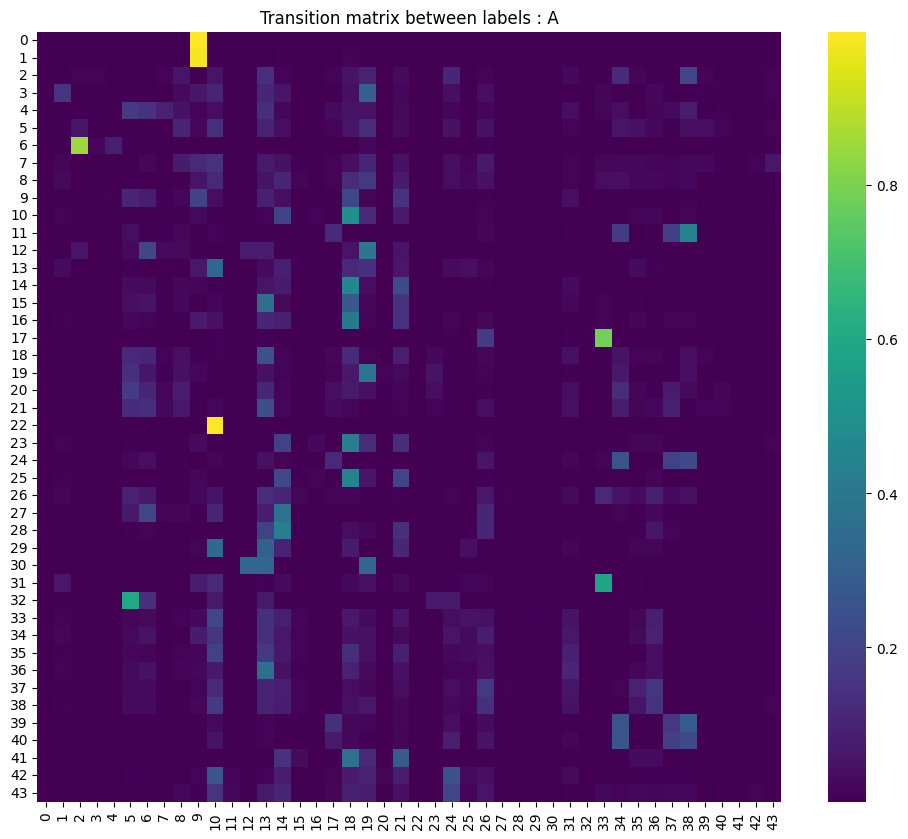

In [56]:
#transition matrix
plt.figure(figsize=(12, 10))
sns.heatmap(A,cmap='viridis')
plt.title("Transition matrix between labels : A")
plt.show()
